## Лабораторная работа №3

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns

TRAIN_PATH = "https://raw.githubusercontent.com/poluzerovT/oiad-2-2025/master/datasets/insurance_train.csv"
TEST_PATH = "https://raw.githubusercontent.com/poluzerovT/oiad-2-2025/master/datasets/insurance_test.csv"

In [33]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)


print('Train shape:', df.shape)
print('Test shape:', df_test.shape)

Train shape: (338, 7)
Test shape: (1000, 7)



--- Пропуски в train ---
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

--- Пропуски в test ---
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

--- Описательная статистика (train) ---
               age   sex         bmi    children smoker     region  \
count   338.000000   338  338.000000  338.000000    338        338   
unique         NaN     2         NaN         NaN      2          4   
top            NaN  male         NaN         NaN     no  southeast   
freq           NaN   176         NaN         NaN    260        102   
mean     38.810651   NaN   30.672751    1.153846    NaN        NaN   
std      13.637734   NaN    6.309709    1.205822    NaN        NaN   
min      18.000000   NaN   17.290000    0.000000    NaN        NaN   
25%      27.000000   NaN   26.053750    0.000000    NaN        NaN   
50%      38.000000   NaN   30.065000    1.000000    NaN 

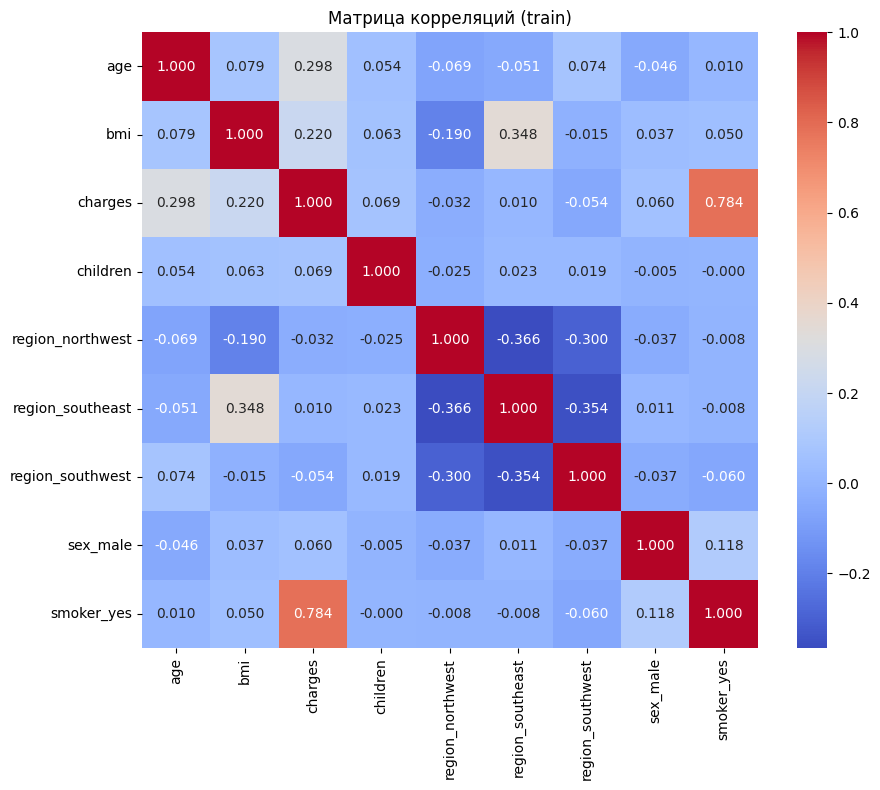

In [34]:
# 1.1 Проверка пропусков
print('\n--- Пропуски в train ---')
print(df.isnull().sum())
print('\n--- Пропуски в test ---')
print(df_test.isnull().sum())

# 1.2 Первичный обзор
print('\n--- Описательная статистика (train) ---')
print(df.describe(include='all'))

# 1.3 Выбросы: простой IQR-метод для числовых столбцов
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('charges')  # целевая

outliers_info = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_out = ((df[col] < lower) | (df[col] > upper)).sum()
    outliers_info[col] = {'lower': lower, 'upper': upper, 'n_outliers': int(n_out)}

print('\n--- Выбросы (IQR) ---')
for k, v in outliers_info.items():
    print(f"{k}: {v['n_outliers']} выбросов; границы [{v['lower']:.3f}, {v['upper']:.3f}]")


# 1.4 Категориальные признаки -> числовые (one-hot)
cat_cols = ['sex', 'smoker', 'region']
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_test_enc = pd.get_dummies(df_test, columns=cat_cols, drop_first=True)

for col in df_enc.columns:
    if col not in df_test_enc.columns:
        df_test_enc[col] = 0
for col in df_test_enc.columns:
    if col not in df_enc.columns:
        df_enc[col] = 0

df_enc = df_enc.sort_index(axis=1)
df_test_enc = df_test_enc[df_enc.columns]

print('\nКолонки после кодирования:')
print(df_enc.columns.tolist())

# 1.5 Корреляции (парные)
plt.figure(figsize=(10,8))
sns.heatmap(df_enc.corr(), annot=True, fmt='.3f', cmap='coolwarm', square=True)
plt.title('Матрица корреляций (train)')
plt.show()


Аналитические веса (без регуляризации):
[14092.8619242   3495.76949182  2210.57176839   581.67513525
   -85.25913065  -638.00136585  -601.39012784  -327.42129485
  9859.84555479]
Early stop at iter 433, Δcost=0.00e+00

Веса (градиентный спуск):
[14092.8619242   3495.76953719  2210.57164319   581.67513084
   -85.25875431  -638.00090895  -601.38973915  -327.42126023
  9859.84559949]

MSE на train: аналитик = 44325092.02597582
MSE на train: gd = 44325092.02597598


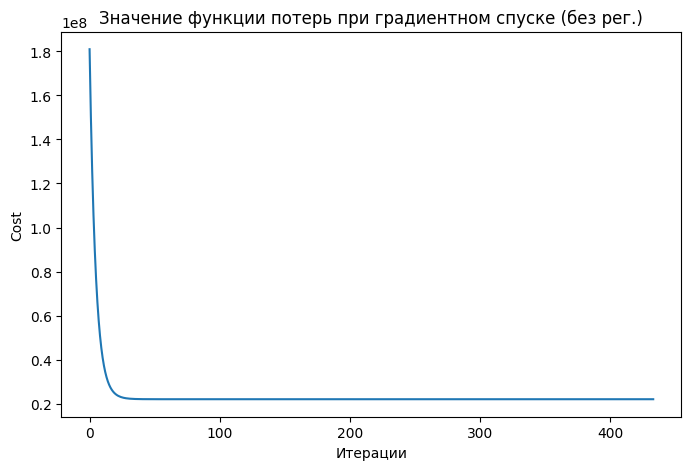

In [35]:
# Подготовим X и y
TARGET = 'charges'
X_train = df_enc.drop(columns=[TARGET]).values
y_train = df_enc[TARGET].values
X_test = df_test_enc.drop(columns=[TARGET]).values
y_test = df_test_enc[TARGET].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_f = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_f = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

# 2.1 Аналитическое решение (Normal Equation)
def analytical_solution(X, y, reg_lambda=0.0):

    m = X.shape[1]
    A = X.T @ X
    if reg_lambda > 0:
        L = reg_lambda * np.eye(m)
        L[0,0] = 0.0
        A = A + L
    theta = np.linalg.pinv(A) @ X.T @ y
    return theta

theta_analytic = analytical_solution(X_train_f, y_train, reg_lambda=0.0)
print('\nАналитические веса (без регуляризации):')
print(theta_analytic)

# 2.2 Градиентный спуск (реализация своими силами)
def gradient_descent(X, y, lr=0.01, n_iterations=5000, tol=1e-8, reg_lambda=0.0, verbose=False):
    n = X.shape[0]
    m = X.shape[1]
    theta = np.zeros(m)
    cost_history = []

    for i in range(n_iterations):
        # 1 вычисляем предсказания и ошибку
        y_pred = X @ theta
        error = y_pred - y

        # 2 считаем cost (перед обновлением theta)
        cost = (1/(2*n)) * np.sum(error**2)
        if reg_lambda > 0:
            cost += (reg_lambda/(2*n)) * np.sum(theta[1:]**2)
        cost_history.append(cost)

        # 3 вычисляем градиент
        grad = (1/n) * (X.T @ error)
        if reg_lambda > 0:
            reg = (reg_lambda / n) * theta
            reg[0] = 0.0
            grad += reg

        # 4 обновляем веса
        theta -= lr * grad

        # 5 проверка условия останова
        if i > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            if verbose:
                print(f"Early stop at iter {i}, Δcost={abs(cost_history[-2]-cost_history[-1]):.2e}")
            break

    return theta, cost_history


theta_gd, cost_hist = gradient_descent(X_train_f, y_train, lr=0.1, n_iterations=20000, tol=1e-9, reg_lambda=0.0, verbose=True)
print('\nВеса (градиентный спуск):')
print(theta_gd)

# Сравним предсказания на train
y_train_pred_analytic = X_train_f @ theta_analytic
y_train_pred_gd = X_train_f @ theta_gd
print('\nMSE на train: аналитик =', mean_squared_error(y_train, y_train_pred_analytic))
print('MSE на train: gd =', mean_squared_error(y_train, y_train_pred_gd))

plt.figure(figsize=(8,5))
plt.plot(cost_hist)
plt.title('Значение функции потерь при градиентном спуске (без рег.)')
plt.xlabel('Итерации')
plt.ylabel('Cost')
plt.show()




Аналитические веса Ridge (alpha= 100.0 ):
[14092.8619242   2758.25309584  1765.78714083   495.51097425
   -64.94327809  -368.06072422  -442.96288329   -59.98094034
  7616.36496357]
Early stop at iter 211, Δcost=0.00e+00

Веса Ridge (gd):
[14092.86192139  2758.25312153  1765.78706996   495.51097176
   -64.94306507  -368.06046561  -442.96266328   -59.98092072
  7616.36498886]


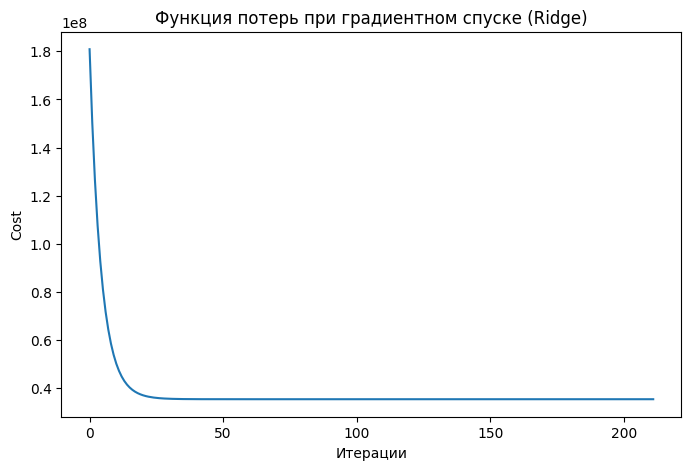

In [36]:

alpha = 100.0
theta_ridge_analytic = analytical_solution(X_train_f, y_train, reg_lambda=alpha)
print('\nАналитические веса Ridge (alpha=', alpha, '):')
print(theta_ridge_analytic)

# 3.2 Градиентный спуск с L2
theta_ridge_gd, cost_ridge_hist = gradient_descent(X_train_f, y_train, lr=0.1, n_iterations=20000, reg_lambda=alpha, tol=1e-9, verbose=True)
print('\nВеса Ridge (gd):')
print(theta_ridge_gd)

plt.figure(figsize=(8,5))
plt.plot(cost_ridge_hist)
plt.title('Функция потерь при градиентном спуске (Ridge)')
plt.xlabel('Итерации')
plt.ylabel('Cost')
plt.show()



In [37]:
results = {}
# 4.1 Константная модель: прогноз средним значением charges на train
mean_train = y_train.mean()
print('\nСреднее charges на train =', mean_train)

y_pred_const = np.full_like(y_test, fill_value=mean_train, dtype=float)
mse_const = mean_squared_error(y_test, y_pred_const)
results['Константная модель (mean train)'] = mse_const

# 4.2 Аналитическая линейная регрессия
y_pred_linear_analytic = X_test_f @ theta_analytic
mse_linear_analytic = mean_squared_error(y_test, y_pred_linear_analytic)
results['Линейная регрессия (аналитическая)'] = mse_linear_analytic

# 4.3 Градиентный спуск (линейная)
y_pred_linear_gd = X_test_f @ theta_gd
mse_linear_gd = mean_squared_error(y_test, y_pred_linear_gd)
results['Линейная регрессия (GD)'] = mse_linear_gd

# 4.4 Ridge аналитический
y_pred_ridge_analytic = X_test_f @ theta_ridge_analytic
mse_ridge_analytic = mean_squared_error(y_test, y_pred_ridge_analytic)
results['Ridge (аналитическая)'] = mse_ridge_analytic

# 4.5 Ridge GD
y_pred_ridge_gd = X_test_f @ theta_ridge_gd
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
results['Ridge (GD)'] = mse_ridge_gd

results_df = pd.DataFrame(list(results.items()), columns=['Модель', 'MSE на тесте'])
print('\nРезультаты на тесте:')
print(results_df)

results_df.to_csv('lab3_results.csv', index=False)
print('\nРезультаты сохранены в lab3_results.csv')



Среднее charges на train = 14092.861924201185

Результаты на тесте:
                               Модель  MSE на тесте
0     Константная модель (mean train)  1.418301e+08
1  Линейная регрессия (аналитическая)  3.421601e+07
2             Линейная регрессия (GD)  3.421601e+07
3               Ridge (аналитическая)  4.024463e+07
4                          Ridge (GD)  4.024463e+07

Результаты сохранены в lab3_results.csv
